In [1]:
import os,sys
import json
import geoplot
import pyproj
import json
import requests
import xlsxwriter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.axes as maxes

import numpy as np
import pandas as pd
import geopandas as gpd


from functools import partial
from shapely.ops import transform
from io import StringIO
from shapely.geometry import Point, Polygon, mapping

%matplotlib inline

In [2]:
datadir = r"./data/"
outputdir = r"C:\TEMP"

if not os.path.isdir(datadir):
    print("warning..data not in place.. install large file system git")
    sys.exit(1)


# Load WMO Member information 
The boundaries, regional info and membership info are all included in the shapefile 

In [3]:
world_shapefile = os.path.join( datadir , "WMO/WMO-shapefile-BCT-ex.shp" )

gdf_world = gpd.read_file( world_shapefile )
gdf_world.crs = "epsg:4326"

print(gdf_world.shape)
gdf_world.head(1)

(214, 12)


,STATUS,TERR_NAME,POL_C_CODE,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,geometry
0,WMO Member,Anguilla,AIA,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,"POLYGON ((-63.15375 18.16528, -63.16778 18.164..."


In [4]:
iso_codes = os.path.join(datadir,"ISO_codes_names.csv")

df_iso = pd.read_csv(iso_codes,encoding='utf-8',sep="\t")
df_iso=df_iso.set_index("ISO3")
df_iso.head()


 
wb_income = os.path.join(datadir,"WB/Metadata_Country_API_AG.LND.TOTL.K2_DS2_en_csv_v2_10578310.csv")

df_income = pd.read_csv(wb_income,encoding='utf-8')
df_income=df_income.set_index("Country Code")[["Region","IncomeGroup"]]
df_income.head()


wb_sids = os.path.join(datadir,"WB/sids.csv")

df_sids = pd.read_csv(wb_sids,encoding='utf-8')
df_sids=df_sids.set_index("Country Code")
df_sids.head()


""
Country Code
ATG
BHR
BHS
BRB
COM


## load geodata and world bank data for surface area 
We combine information from the World Bank (surface eare), marineregions.org (EEZs and inland lakes)
We also process data, e.g to add Greenland to Denmark and complete missing data (e.g Sudan)

In [5]:
# EEZs 
gdf_surface = gpd.read_file("zip://"+os.path.join( datadir , 'EEZ/EEZ_land_union_v3_wmo_v2.zip')  )
gdf_surface.crs = "epsg:4326"

gdf_surface = gdf_surface[["TERRITORY1","SOVEREIGN1","ISO_TER1","POL_TYPE","ISO_SOV1","AREA_KM2","AREA2_KM2","UNION","WMO_Region","geometry"]]
#gdf_surface = gdf_surface[["ISO_TER1","geometry"]]

# no joint regimes or overlapping
idx_joint=gdf_surface.POL_TYPE.str.contains("Joint regime",na=False)
idx_overlapping=gdf_surface.POL_TYPE.str.contains("Overlapping claim",na=False)
gdf_surface=gdf_surface[~idx_joint & ~idx_overlapping]

# aggregate by ISO_TER1
gdf_surface.UNION=gdf_surface.UNION.apply(lambda x : str(x))
gdf_surface.TERRITORY1=gdf_surface.TERRITORY1.apply(lambda x : str(x))
gdf_surface.POL_TYPE=gdf_surface.POL_TYPE.apply(lambda x : str(x))

agg={"AREA_KM2":sum,"AREA2_KM2":sum,"ISO_SOV1":"first","SOVEREIGN1":"first",
     "UNION":lambda x: ', '.join(x),
     "POL_TYPE":lambda x: ', '.join(x),
     "TERRITORY1":lambda x: ', '.join(x),
     "WMO_Region":lambda x: ', '.join(x)
    }

gdf_surface=gdf_surface.dissolve(by="ISO_TER1",aggfunc=agg)

gdf_surface.WMO_Region=gdf_surface.WMO_Region.apply(lambda x : ",".join(set(x.split(", ")) ) )
gdf_surface.loc["COL","WMO_Region"] = 3 # Colombia counted towards RA III
gdf_surface.WMO_Region=gdf_surface.WMO_Region.astype(np.int8)

gdf_surface.head()

,geometry,AREA_KM2,AREA2_KM2,ISO_SOV1,SOVEREIGN1,UNION,POL_TYPE,TERRITORY1,WMO_Region
ISO_TER1,,,,,,,,,
ABW,"POLYGON ((-68.87017 15.24185, -68.88133 15.200...",30197,3.026461e+04,NLD,Netherlands,Aruba,Union EEZ and country,Aruba,4
AFG,"POLYGON ((70.99982 38.47927, 71.00838 38.47060...",641860,6.420717e+05,AFG,Afghanistan,Afghanistan,Landlocked country,Afghanistan,2
AGO,"MULTIPOLYGON (((14.01203 -5.83827, 14.01323 -5...",1742906,1.749601e+06,AGO,Angola,Angola,Union EEZ and country,Angola,1
AIA,"POLYGON ((-60.73667 20.92203, -60.76437 20.877...",90247,9.050389e+04,GBR,United Kingdom,Anguilla,Union EEZ and country,Anguilla,4
ALB,"POLYGON ((20.00835 39.69182, 20.00810 39.69187...",40954,4.090000e+04,ALB,Albania,Albania,Union EEZ and country,Albania,6


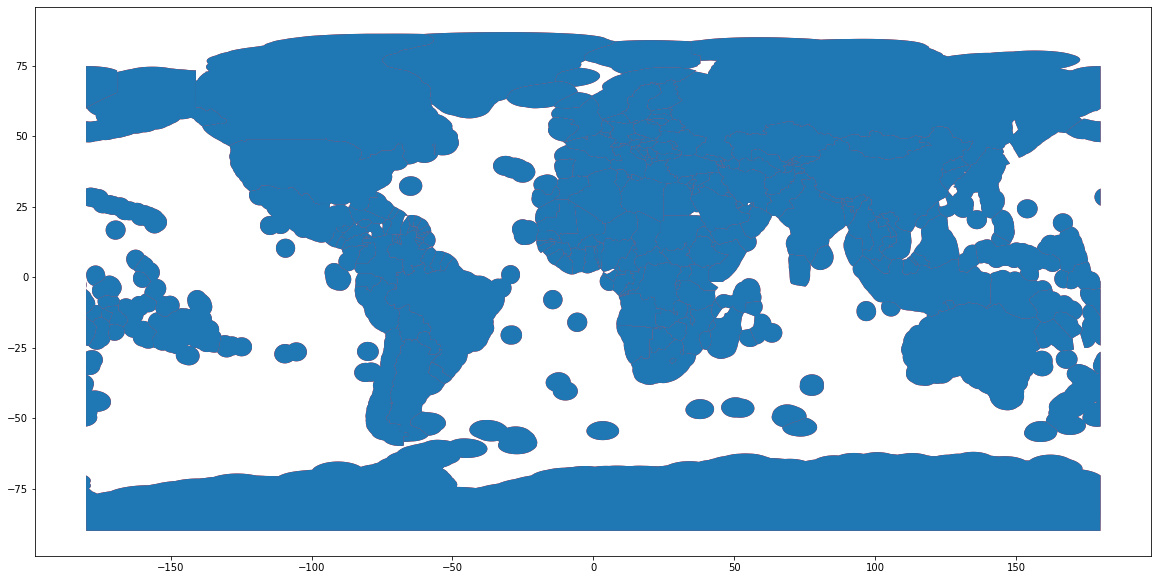

In [6]:
ax=gdf_surface.plot(figsize=(20,20),color="red")
gdf_surface.plot(ax=ax)

#gdf_surface[gdf_surface.ISO_TER1.isna()].plot(ax=ax,color="yellow")

## station data from WDQMS

In [7]:
def load_data(analysis_type="SYNOP"):

    if analysis_type == "SYNOP":
        files = ["synop_ecmwf_2020_01_01-09.csv.gz","synop_ecmwf_2020_01_10-19.csv.gz","synop_ecmwf_2020_01_20-29.csv.gz","synop_ecmwf_2020_01_30-31.csv.gz"]
        var_id = 110
    elif analysis_type == "UA":
        files = ["temp_ecmwf_2020_01.csv.gz",]
        var_id = 1
    else:
        raise Exception("analysis type not supported")

    df_stations=None 
    for f in files:
        f = os.path.join( datadir,  "WDQMS/{}".format(f))

        df = pd.read_csv(f)
        df=df[df.var_id==var_id]

        df_stations = pd.concat( [df_stations,df] )

    df_stations.dropna(how="all",inplace = True) 

    tmp = df_stations["name.1"].str.split("_",expand=True)
    df_stations["center"] = tmp[1]
    df_stations["datetime"] = pd.to_datetime( tmp[0] , format="%Y%m%d%H" )

    df_stations.drop(columns=["name.1",],inplace=True)

    country_map = {"ROM":"ROU", "CW":"CUW","SX":"SXM"}
    df_stations.country_id = df_stations.country_id.replace(country_map)

    #df_stations.loc[df_stations.country_id=="ROM","country_id"] = "ROU" #incorrect country code for Roumania in WDQMS    
    #df_stations.loc[df_stations.country_id=="GRL","country_id"] = "DNK" #count Greenland stations towards Denmark    


    geometry = [Point(xy) for xy in zip(df_stations.longitude , df_stations.latitude)]
    crs =  'epsg:4326' 
    gdf_stations = gpd.GeoDataFrame(df_stations[["wigosid","name","nr_received","nr_expected","datetime","country_id"]], crs=crs, geometry=geometry)

    return gdf_stations
    
gdf_stations = load_data()
gdf_ua_stations = load_data(analysis_type="UA")
    
print(gdf_stations.shape)
print(gdf_ua_stations.shape)


(1378163, 7)
(122153, 7)


In [8]:
# baseline of stations. All unique stations
gdf_baseline=gdf_stations.drop_duplicates(subset="wigosid")
#gdf_baseline.drop("datetime",axis=1).to_file("baseline-{}.shp".format(analysis_type))
gdf_baseline=gdf_baseline.set_index("wigosid")

gdf_ua_baseline=gdf_ua_stations[gdf_ua_stations.nr_received>0].drop_duplicates(subset="wigosid")
#gdf_baseline.drop("datetime",axis=1).to_file("baseline-{}.shp".format(analysis_type))
gdf_ua_baseline=gdf_ua_baseline.set_index("wigosid")

In [9]:
# stations that are reporting. At least 30% of expected reports on at least 60% of occasions 
per_exp = 0.3
per_occ = 0.6
GBON_per_6h = 6 # 1h observations

gdf_reporting=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
gdf_reporting=gpd.GeoDataFrame( gdf_reporting.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
gdf_reporting.crs = "epsg:4326"
gdf_reporting=gdf_reporting[gdf_reporting.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
#print(gdf_reporting.shape)

#gdf_reporting.to_file("reporting-SYNOP.shp")

#per_exp = 0.8

#gdf_reporting_2=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
#gdf_reporting_2=gpd.GeoDataFrame( gdf_reporting_2.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
#gdf_reporting_2.crs = "epsg:4326"
#gdf_reporting_2=gdf_reporting_2[gdf_reporting_2.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
    
per_exp = 1
per_occ = 0.6
GBON_daily_2 = 2
GBON_daily = 1

# 2 daily 
tmp=gdf_ua_stations.set_index("datetime").groupby([pd.Grouper(freq="D"),"wigosid"]).agg({"nr_received":"sum","geometry":"first","country_id":"first","name":"first"})
gdf_ua_reporting_2=gpd.GeoDataFrame(tmp[tmp.nr_received >= GBON_daily_2 * per_exp].groupby("wigosid").agg({"nr_received":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"nr_received":"nr_ok_days"}))
gdf_ua_reporting_2.crs = "epsg:4326"
gdf_ua_reporting_2=gdf_ua_reporting_2[gdf_ua_reporting_2.nr_ok_days >= 31 * per_occ ]

# 1 daily (but not 2 daily)
tmp=gdf_ua_stations.set_index("datetime").groupby([pd.Grouper(freq="D"),"wigosid"]).agg({"nr_received":"sum","geometry":"first","country_id":"first","name":"first"})
gdf_ua_reporting=gpd.GeoDataFrame(tmp[(tmp.nr_received >= GBON_daily * per_exp) & ~(tmp.nr_received >= GBON_daily_2 * per_exp) ].groupby("wigosid").agg({"nr_received":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"nr_received":"nr_ok_days"}))
gdf_ua_reporting.crs = "epsg:4326"
gdf_ua_reporting=gdf_ua_reporting[gdf_ua_reporting.nr_ok_days >= 31 * per_occ ]


#gdf_reporting.to_file("reporting-UA.shp")
    

print(len(gdf_baseline)," SYOP baseline stations")
print(len(gdf_reporting)," SYNOP reporting stations")

print(len(gdf_ua_baseline)," UA baseline stations")
print(len(gdf_ua_reporting)," UA reporting stations (1 daily)")
print(len(gdf_ua_reporting_2)," UA reporting stations (2 daily)")


11267  SYOP baseline stations
7567  SYNOP reporting stations
820  UA baseline stations
167  UA reporting stations (1 daily)
550  UA reporting stations (2 daily)


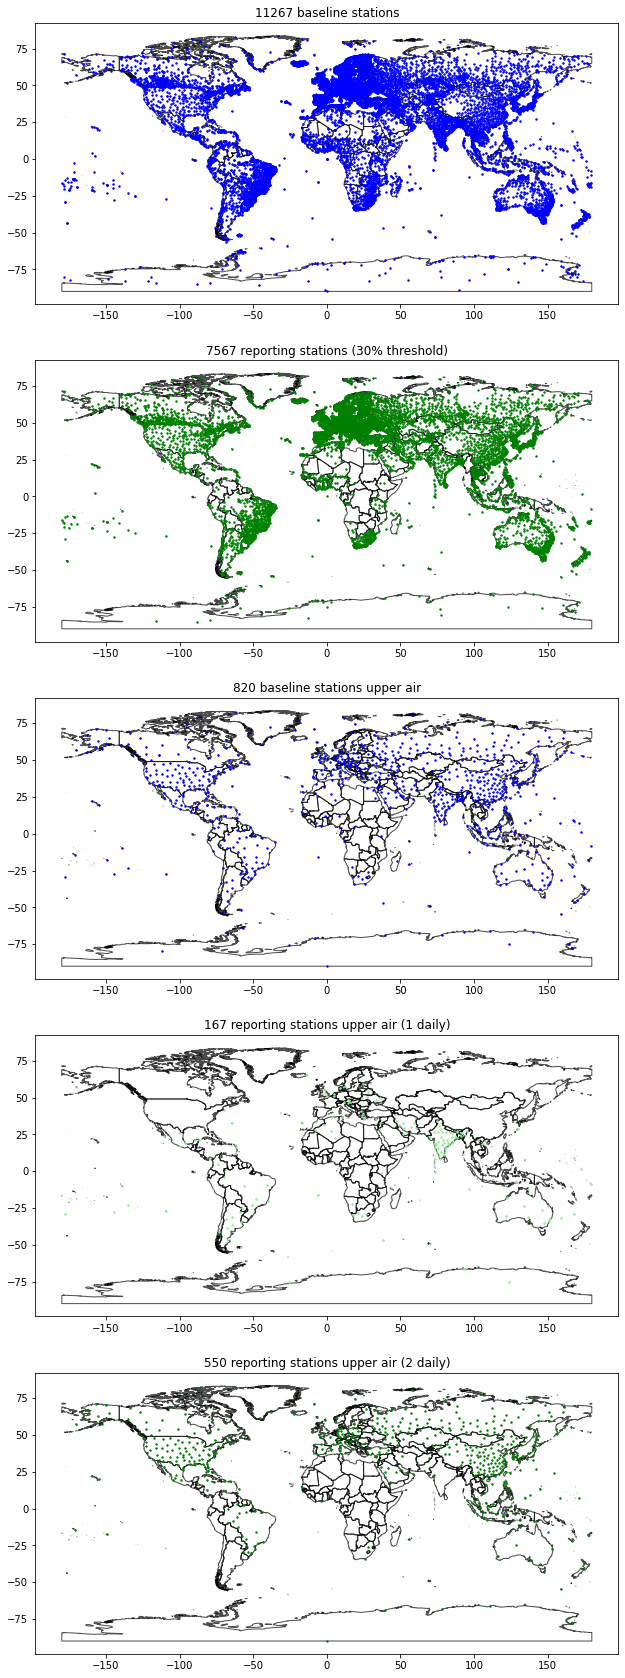

In [10]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(15,30))

gdf_world.plot(ax=ax1,alpha=0.7,facecolor="none")
gdf_baseline.plot(ax=ax1,markersize=2,color="blue")
ax1.set_title("{} baseline stations".format(len(gdf_baseline)))

gdf_world.plot(ax=ax2,alpha=0.7,facecolor="none")
gdf_reporting.plot(ax=ax2,markersize=2,color="green")
ax2.set_title("{} reporting stations (30% threshold)".format(len(gdf_reporting)))

gdf_world.plot(ax=ax3,alpha=0.7,facecolor="none")
gdf_ua_baseline.plot(ax=ax3,markersize=2,color="blue")
ax3.set_title("{} baseline stations upper air".format(len(gdf_ua_baseline)))

gdf_world.plot(ax=ax4,alpha=0.7,facecolor="none")
gdf_ua_reporting.plot(ax=ax4,markersize=2,color="lightgreen")
ax4.set_title("{} reporting stations upper air (1 daily)".format(len(gdf_ua_reporting)))

gdf_world.plot(ax=ax5,alpha=0.7,facecolor="none")
gdf_ua_reporting_2.plot(ax=ax5,markersize=2,color="green")
ax5.set_title("{} reporting stations upper air (2 daily)".format(len(gdf_ua_reporting_2)))
   
fig.savefig(os.path.join(outputdir,"GBON-coverage-map.png"))

In [11]:
def station_to_country(stations,plot=False):
    stations=gpd.sjoin(stations,gdf_surface.reset_index()[["ISO_TER1","ISO_SOV1","geometry"]],how="left",op="within")
    
    idx_nojoin = stations.index_right.isna()
    print("warning.. could not find country for ",stations.loc[idx_nojoin,["name","wigosid"]])

    if plot:
        ax=gdf_surface.plot(figsize=(20,20))
        stations[~idx_nojoin].plot(ax=ax,color="green",markersize=2,label="in country",legend=True)
        stations[idx_nojoin].plot(ax=ax,color="red",markersize=4,label="not in country",legend=True)

    return stations

baseline_stations = station_to_country(gdf_baseline)
reporting_stations_30 = station_to_country(gdf_reporting)

baseline_ua_stations = station_to_country(gdf_ua_baseline)
reporting_ua_stations = station_to_country( pd.concat([gdf_ua_reporting,gdf_ua_reporting_2])) # 1 and 2 daily together
#reporting_ua_stations_2 = station_to_country(gdf_ua_reporting_2)

#reporting_stations_80 = station_to_country(gdf_reporting_2)

warning.. could not find country for                                           name  wigosid
0-20000-0-59997                    NANSHA DAO      NaN
0-20000-0-61967        DIEGO GARCIA (61967-0)      NaN
0-20000-0-40890                      ABU MUSA      NaN
85032                                 Unknown      NaN
41210                                 Unknown      NaN
0-20000-0-48892  SONG TU TAY (SOUTH WEST CAY)      NaN
0-20000-0-32165               JUZHNO-KURIL'SK      NaN
0-20000-0-61976   SERGE-FROLOW (ILE TROMELIN)      NaN
0-20000-0-67005            PAMANDZI (MAYOTTE)      NaN
0-20000-0-61968               ILES GLORIEUSES      NaN
0-20000-0-89009                AMUNDSEN-SCOTT      NaN
0-20000-0-61966        DIEGO GARCIA (61966-0)      NaN
0-20000-0-60338             MELILLA (60338-0)      NaN
0-20000-0-60320                         CEUTA      NaN
85116                                 Unknown      NaN
76553                                 Unknown      NaN
warning.. could not find co

In [12]:
idx_outside = (baseline_stations.country_id != baseline_stations.ISO_TER1) & (baseline_stations.country_id != baseline_stations.ISO_SOV1)       
baseline_stations[idx_outside & ~baseline_stations.country_id.isna() ].head()

,name,nr_received,nr_expected,datetime,country_id,geometry,index_right,ISO_TER1,ISO_SOV1
0-20000-0-38957,ISHKASHIM,1,2,2020-01-06,TJK,POINT (71.60000 36.71667),1.0,AFG,AFG
0-20000-0-38856,DARVAZ,1,2,2020-01-06,TJK,POINT (70.88333 38.46667),1.0,AFG,AFG
0-508-0-67257,ZOBWE,0,2,2020-01-06,MOZ,POINT (34.76670 -15.55000),154.0,MWI,MWI
0-380-8-1,TALOS DOME,0,2,2020-01-06,ITA,POINT (159.19330 -72.82910),10.0,ATA,ATA
0-20000-0-89873,ELAINE,0,2,2020-01-06,USA,POINT (174.16667 -83.13333),10.0,ATA,ATA


In [13]:
def correct_outliers(stations,plot=False):
    
    print("len stations:",len(stations))
 
    idx_outside = (stations.country_id != stations.ISO_TER1) & (stations.country_id != stations.ISO_SOV1) & ~stations.country_id.isna()

    outliers = stations[idx_outside].copy() # if there's no country_id we believe the geo matching
    stations = stations[~idx_outside].copy()

    print("len outliers:",len(outliers))
    print("len stations:",len(stations))

    
    outliers["near_home"] = False

    for i,o in outliers.iterrows():
        country_id = o.country_id
        if not o.country_id in gdf_surface.index.values: #discard stations 
            print("discarding",o.country_id)
            continue
        try:
            country_geom = gdf_surface.loc[ o.country_id, : ].geometry
            station_geom = o.geometry

            d=station_geom.distance(country_geom)
            outliers.loc[i,"near_home"] = d <= 0.5
        except TypeError as te:
            print("issue with:",te)
            traceback.print_exc(file=sys.stdout)

    # we trust the country_id if it is near the country (country boundaries not exact enough for border stations)
    outliers.loc[outliers.near_home,"ISO_TER1"] = outliers.loc[outliers.near_home,"country_id"]
    #print(outliers.loc[outliers.near_home,:])
    
    # remove stations outside any territory
    outliers.drop(outliers[outliers.ISO_TER1.isna()].index,inplace=True)

    # some entities are trusted to overwrite the country id. We keep them. Drop the rest
    trusted_entities = ["SGS","TWN","ESH","ATA"]
    idx_trusted = outliers.ISO_TER1.isin(trusted_entities)
    outliers.drop(outliers[~outliers.near_home & ~idx_trusted ].index,inplace=True)

    if plot:
        ax=gdf_surface.plot(figsize=(20,20))
        outliers[outliers.near_home].plot(ax=ax,color="yellow",markersize=4)
        outliers[~outliers.near_home].plot(ax=ax,color="red",markersize=4)
        outliers.to_csv(r"C:\TEMP\outliers.csv")        

    
    print("number outliers kept:",len(outliers))

    res = pd.concat( [ stations, outliers.drop("near_home",axis=1) ] )
    
    print("len result",len(res))
        
    return res

baseline_stations = correct_outliers(baseline_stations,plot=False)
reporting_stations_30 = correct_outliers(reporting_stations_30)

baseline_ua_stations = correct_outliers(baseline_ua_stations,plot=False)
reporting_ua_stations = correct_outliers(reporting_ua_stations,plot=False)
#reporting_ua_stations_2 = correct_outliers(reporting_ua_stations_2,plot=False)

len stations: 11267
len outliers: 165
len stations: 11102
number outliers kept: 153
len result 11255
len stations: 7567
len outliers: 80
len stations: 7487
number outliers kept: 71
len result 7558
len stations: 820
len outliers: 16
len stations: 804
number outliers kept: 15
len result 819
len stations: 717
len outliers: 14
len stations: 703
number outliers kept: 13
len result 716


In [14]:
reporting_ua_stations.head()

,nr_ok_days,geometry,country_id,name,index_right,ISO_TER1,ISO_SOV1
0-20000-0-02527,30,POINT (12.29111 57.65722),SWE,GOTEBORG/LANDVETTER,207.0,SWE,SWE
0-20000-0-03238,31,POINT (-1.88167 55.01972),GBR,ALBEMARLE,79.0,GBR,GBR
0-20000-0-03354,23,POINT (-1.25111 53.00556),GBR,"NOTTINGHAM, WATNALL",79.0,GBR,GBR
0-20000-0-03882,27,POINT (0.31694 50.89944),GBR,"HERSTMONCEUX, WEST END",79.0,GBR,GBR
0-20000-0-03918,25,POINT (-6.33333 54.50000),GBR,CASTOR BAY,79.0,GBR,GBR


In [15]:
def calculate_HR(stations,colsuffix=None):
    
    colname="HR_" + colsuffix
    colname_stations = "nr_stations_" + colsuffix

    stations_by_country = stations.groupby("ISO_TER1").ISO_SOV1.count().to_frame()
    stations_by_country = stations_by_country.rename(columns={"ISO_SOV1":colname_stations})
    
    country_hr = stations_by_country.join(gdf_surface,how="right")
    
    country_hr[colname] = np.sqrt(country_hr.AREA_KM2) / np.sqrt(country_hr[colname_stations])
    
    country_hr[colname_stations] = country_hr[colname_stations].fillna(0) 
    
    return country_hr[[colname,colname_stations]]
        
hr_baseline = calculate_HR(baseline_stations,"baseline")
hr_reporting_30 = calculate_HR(reporting_stations_30,"reporting")
#hr_reporting_80 = calculate_HR(reporting_stations_80,"reporting_80")

hr_baseline_ua = calculate_HR(baseline_ua_stations,"baseline")
hr_reporting_ua = calculate_HR(reporting_ua_stations,"reporting")
#hr_reporting_ua_2 = calculate_HR(reporting_ua_stations_2,"reporting_ua_2")


df_analysis = pd.concat([hr_baseline,hr_reporting_30],axis=1)
df_analysis_ua = pd.concat([hr_baseline_ua,hr_reporting_ua],axis=1)


df_analysis.head()

,HR_baseline,nr_stations_baseline,HR_reporting,nr_stations_reporting
ISO_TER1,,,,
ABW,173.772840,1.0,173.772840,1.0
AFG,231.275449,12.0,NaN,0.0
AGO,311.172157,18.0,NaN,0.0
AIA,300.411385,1.0,NaN,0.0
ALB,63.995312,10.0,67.456982,9.0


# nearest neighbours 

In [16]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1, n_nearest=0):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[n_nearest]
    closest_dist = distances[n_nearest]

    # Return indices and distances
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians, k_neighbors=2, n_nearest=1)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

#gdf_german_stations = gdf_baseline[gdf_baseline.country_id=="DEU"].reset_index().drop("index",axis=1)
#closest_german_stations = nearest_neighbor( gdf_german_stations, gdf_german_stations, return_dist=True)
#closest_german_stations
#closest_german_stations.join(gdf_german_stations,rsuffix="_right").head()

NameError: name 'nn_hr_reporting_30' is not defined

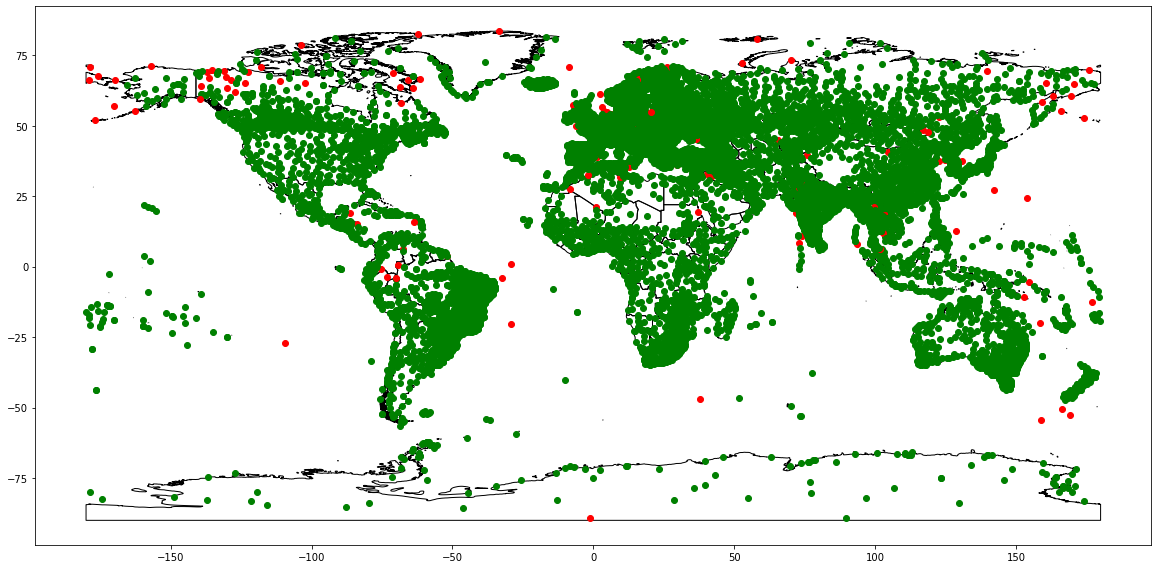

In [17]:
fig,ax=plt.subplots(1,figsize=(20,10))
gdf_world.plot(ax=ax,edgecolor="black",facecolor="None")


def calculate_HR_NN(stations):

    res = {}
    
    for country_id in gdf_surface.index.values:
    
        tmp_stations = stations[stations.ISO_TER1==country_id].reset_index().drop("index",axis=1)
        if len(tmp_stations) > 1:
            closest_stations = nearest_neighbor( tmp_stations, tmp_stations, return_dist=True)
            

            # remove points exceeding the std by more than 3
            distance = closest_stations["distance"]
            std = distance.std()
            mean = distance.mean()
            
            z_score = (distance - mean) / std
            
            idx_outliers = z_score > 3
            #print("removing ",idx_outliers.sum()," outliers in",country_id," from ",len(tmp_stations),"std:",std)
            if idx_outliers.sum()>0:
                tmp_stations[idx_outliers].plot(ax=ax,color="red")
            tmp_stations[~idx_outliers].plot(ax=ax,color="green")
            
            mean = distance[~idx_outliers].mean()
        else:
            mean,std = np.nan , np.nan
    
        res[country_id] =  {"mean" : mean , "std" : std }
        
    return pd.DataFrame.from_dict(res,orient="index")

nn_hr_baseline = calculate_HR_NN(baseline_stations)
#nn_hr_reporting_30 = calculate_HR_NN(reporting_stations_30)
#nn_hr_reporting_80 = calculate_HR_NN(reporting_stations_80)

tmp=pd.concat([nn_hr_baseline,nn_hr_reporting_30],axis=1)

newcols = [ "HR_NN_{}_{}".format(c,b) for c in ["baseline","reporting"] for b in ["mean","std"] ]
tmp.columns = newcols

In [17]:
df_analysis=df_analysis.join(tmp)
nn_cols = [ "HR_NN_{}_{}".format(c,b) for c in ["baseline","reporting"] for b in ["mean","std"] ]
#newcols = [ "HR_KDE_{}_{}".format(c,b) for c in ["baseline","reporting_30"] for b in ["mean","std","std_normalized"] ]
df_analysis[nn_cols] = df_analysis[nn_cols] / 1000 # convert meters to kilometers


## and UA

nn_hr_baseline_ua = calculate_HR_NN(baseline_ua_stations)
nn_hr_reporting_ua = calculate_HR_NN(reporting_ua_stations)
#nn_hr_reporting_2_ua = calculate_HR_NN(reporting_ua_stations_2)

tmp=pd.concat([nn_hr_baseline_ua,nn_hr_reporting_ua],axis=1)

newcols = [ "HR_NN_{}_{}".format(c,b) for c in ["baseline","reporting"] for b in ["mean","std"] ]
tmp.columns = newcols

df_analysis_ua=df_analysis_ua.join(tmp)
nn_cols = [ "HR_NN_{}_{}".format(c,b) for c in ["baseline","reporting"] for b in ["mean","std"] ]
#newcols = [ "HR_KDE_{}_{}".format(c,b) for c in ["baseline","reporting_30"] for b in ["mean","std","std_normalized"] ]
df_analysis_ua[nn_cols] = df_analysis_ua[nn_cols] / 1000 # convert meters to kilometers

In [18]:
df_analysis_ua.head()

,HR_baseline,nr_stations_baseline,HR_reporting,nr_stations_reporting,HR_NN_baseline_mean,HR_NN_baseline_std,HR_NN_reporting_mean,HR_NN_reporting_std
ISO_TER1,,,,,,,,
ABW,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
AFG,801.161657,1.0,801.161657,1.0,NaN,NaN,NaN,NaN
AGO,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
AIA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
ALB,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [19]:
cols = ["AREA_KM2","ISO_SOV1","SOVEREIGN1","TERRITORY1","POL_TYPE","UNION","WMO_Region"]
df_analysis=df_analysis.join(gdf_surface[cols]).join(df_iso).join(df_income,on="ISO_SOV1",rsuffix="wb_")
df_analysis_ua=df_analysis_ua.join(gdf_surface[cols]).join(df_iso).join(df_income,on="ISO_SOV1",rsuffix="wb_")

In [32]:
# add SID status
df_sids["SID"]=True
df_analysis=df_analysis.join(df_sids)
df_analysis_ua=df_analysis_ua.join(df_sids)

In [34]:
# add number of m
    
def calculate_nr_target(df_orig,gbon_hr=200,baseline_name="nr_stations_baseline",reporting_name="nr_stations_reporting"):
    df=df_orig[["AREA_KM2",reporting_name,baseline_name]].fillna(0).copy()
    
    colname = "nr_station_gbon_target"
    
    df[colname] = np.ceil( np.power(np.sqrt(df.AREA_KM2) / gbon_hr , 2) )

    df["nr_stations_policy"] = 0
    df["nr_stations_new"] = 0
    
    
    # target not reached with reporting stations, but can be reached with baseline stations
    idx_under_target = ((df[colname] > df[reporting_name]) & (df[baseline_name] >= df[colname]))
    df.loc[idx_under_target,"nr_stations_policy"] =  df.loc[idx_under_target,colname]-df.loc[idx_under_target,reporting_name]
    
    # target not reached with reporting + baseline stations
    idx_under_target2 = (df[baseline_name] < df[colname])
    df.loc[idx_under_target2,"nr_stations_policy"] = df.loc[idx_under_target2,baseline_name]-df.loc[idx_under_target2,reporting_name]
    df.loc[idx_under_target2,"nr_stations_new"] = df.loc[idx_under_target2,colname]-df.loc[idx_under_target2,"nr_stations_policy"]-df.loc[idx_under_target2,reporting_name]
        
    return df_orig.join(df[["nr_station_gbon_target","nr_stations_policy","nr_stations_new"]])

    #hr = sqrt(AREA) / SQRT(nr_stations) #    country_hr[colname] = np.sqrt(country_hr.AREA_KM2) / np.sqrt(country_hr[colname_stations])

    #-> hr * sqrt(nr_stations) = sqrt(area)
    #-> sqrt(nr_stations) = sqrt(area) / hr
    # => nr_stations = (sqrt(area) / hr ) ^2
    
    
output=calculate_nr_target(df_analysis)    
output_ua=calculate_nr_target(df_analysis_ua,gbon_hr=500)    


In [35]:
col_order=["SOVEREIGN1" ,"name","AREA_KM2","nr_station_gbon_target","nr_stations_policy","nr_stations_new","HR_baseline","HR_reporting","nr_stations_baseline","nr_stations_reporting"] + nn_cols + ["ISO_SOV1","UNION","IncomeGroup","SID","WMO_Region"]
output[col_order].sort_values(["SOVEREIGN1","name"])

,SOVEREIGN1,name,AREA_KM2,nr_station_gbon_target,nr_stations_policy,nr_stations_new,HR_baseline,HR_reporting,nr_stations_baseline,nr_stations_reporting,HR_NN_baseline_mean,HR_NN_baseline_std,HR_NN_reporting_mean,HR_NN_reporting_std,ISO_SOV1,UNION,IncomeGroup,SID,WMO_Region
ISO_TER1,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Afghanistan,641860,17.0,12.0,5.0,231.275449,1000.000000,12.0,0.0,104.089565,63.591916,NaN,NaN,AFG,Afghanistan,Low income,NaN,2
ALB,Albania,Albania,40954,2.0,0.0,0.0,63.995312,67.456982,10.0,9.0,48.026201,31.073767,46.917606,32.748287,ALB,Albania,Upper middle income,NaN,6
DZA,Algeria,Algeria,2444284,62.0,28.0,0.0,157.129683,268.124422,99.0,34.0,76.661327,92.242248,158.375223,151.111673,DZA,Algeria,Upper middle income,NaN,1
AND,Andorra,Andorra,468,1.0,0.0,1.0,1000.000000,1000.000000,0.0,0.0,NaN,NaN,NaN,NaN,AND,Andorra,High income,NaN,6
AGO,Angola,Angola,1742906,44.0,18.0,26.0,311.172157,1000.000000,18.0,0.0,179.052056,65.911084,NaN,NaN,AGO,Angola,Lower middle income,NaN,1
ATA,Antarctica,Antarctica,22143430,554.0,66.0,439.0,438.806979,672.240087,115.0,49.0,307.614648,342.837558,501.129789,629.507827,ATA,Antarctica,NaN,NaN,7
ATG,Antigua and Barbuda,Antigua and Barbuda,112004,3.0,0.0,2.0,334.669987,334.669987,1.0,1.0,NaN,NaN,NaN,NaN,ATG,Antigua and Barbuda,High income,True,4
ARG,Argentina,Argentina,3851647,97.0,9.0,14.0,215.419093,228.143121,83.0,74.0,81.360241,43.361486,85.936264,49.659952,ARG,Argentina,High income,NaN,3
ARM,Armenia,Armenia,29733,1.0,0.0,0.0,43.108149,99.554005,16.0,3.0,24.004104,13.127814,81.144385,11.081015,ARM,Armenia,Upper middle income,NaN,6


In [36]:
# any wrong calculations
idx_test = (output.nr_station_gbon_target > output.nr_stations_reporting) & (output.nr_station_gbon_target != output.nr_stations_new + output.nr_stations_policy + output.nr_stations_reporting)
output[idx_test][col_order]

,SOVEREIGN1,name,AREA_KM2,nr_station_gbon_target,nr_stations_policy,nr_stations_new,HR_baseline,HR_reporting,nr_stations_baseline,nr_stations_reporting,HR_NN_baseline_mean,HR_NN_baseline_std,HR_NN_reporting_mean,HR_NN_reporting_std,ISO_SOV1,UNION,IncomeGroup,SID,WMO_Region
ISO_TER1,,,,,,,,,,,,,,,,,,,


In [40]:
with pd.ExcelWriter( os.path.join(outputdir,'GBON-HZ.xlsx'), engine='xlsxwriter') as writer:
    output[col_order].sort_values(["SOVEREIGN1","name"]).to_excel(writer,"Surface")
    output_ua[col_order].sort_values(["SOVEREIGN1","name"]).to_excel(writer,"Upper-Air")
    
    for sheetname in ["Surface","Upper-Air"]:      
        workbook  = writer.book
        worksheet = writer.sheets[sheetname]
        format1 = workbook.add_format({'num_format': '0.00'})
        for c in ["H:I","L:O"]:
            worksheet.set_column(c, None, format1)  # Adds formatting to column C
        
        num_format = workbook.add_format({'num_format': '#,###'})
        worksheet.set_column('D:D', None, num_format)
        
    
    pd.read_csv(os.path.join(datadir,"dd.csv"),header=None).to_excel(writer,"Data Dictionary",header=["Field","Description"],index=False)
        
        
    writer.save()

In [24]:
# pre-project geodataframes for faster plotting
myproj = "eck4" # eqearth,moll
gdf_surface_proj = gdf_surface.to_crs("+proj={}".format(myproj))
gdf_world_proj  = gdf_world.to_crs("+proj={}".format(myproj))

In [25]:
def plot_HR(df,column,title,ax,ticks=None,norm=False,cmap=False,highres=False,vcenter=200,vmax=1000,label=None):
    """Plots the HR indicated in `column` into the map passed in `df`.
    The EEZ of the country are also plotted in the same color.
    Non-WMO Member states are plotted in grey with red borders.
    WMO Members with zero HR are shown grey
    """
    
    # set max value for NA values
    df[column]=df[column].fillna( vmax )
    
    # join data to member info
    df = gdf_surface_proj.join(df[column],how="left")
        
    #colors
    nodata_color = "grey"
    
    cmap = "coolwarm" if not cmap else cmap
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=vcenter, vmax=vmax) if not norm else norm   
    
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # plot countries
    df.plot(column=column, legend=False, cmap=cmap, norm=norm, ax=ax )
    gdf_world_proj.plot(edgecolor="white",facecolor="None",linewidth=0.15,  ax=ax)
    
    # configure plot
    ax.set_title(title, fontsize=15)
   
    
    ax_cbar = fig.colorbar( cbar , ax=ax ,shrink=0.75 )
    ax_cbar.set_label('Horizontal resolution in km')
    if ticks:
        ticks=[str(t)  for t in ticks[0:-1]] +  ["Inf.",]
        ax_cbar.ax.set_yticklabels(ticks)
    
    # add additional legend
    #red_patch = mpatches.Patch( edgecolor="red",facecolor="lightgrey",linewidth=2,label="not WMO Member")
    #grey_patch = mpatches.Patch(facecolor=nodata_color, label='no stations')
    #ax.legend(handles=[red_patch,grey_patch])
    
    ax.axis("off")
    
    if label:
        ax.text(0.5,-0.05, label, size=12, ha="center", transform=ax.transAxes)

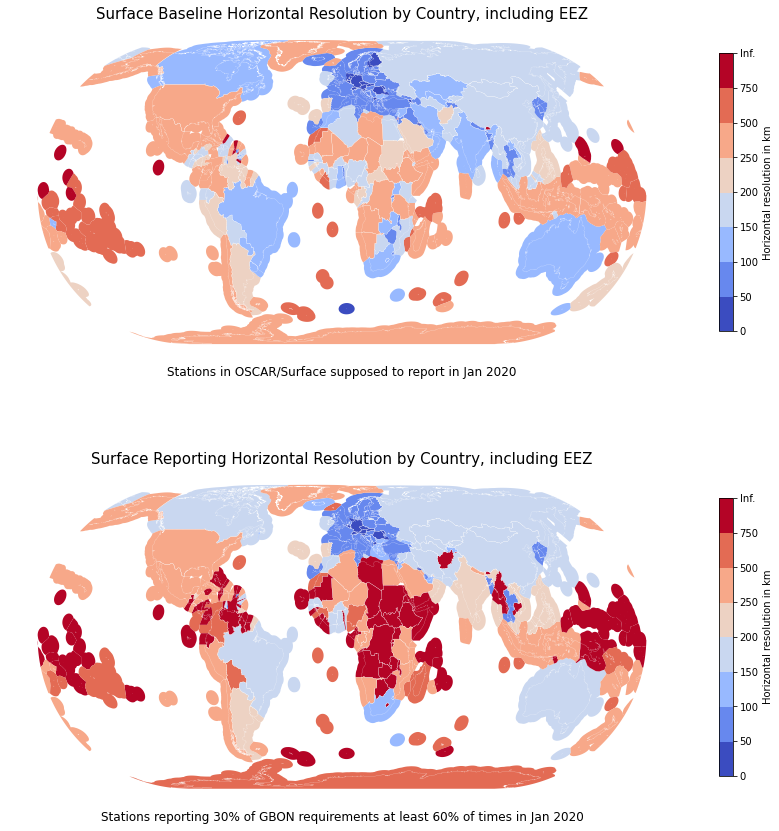

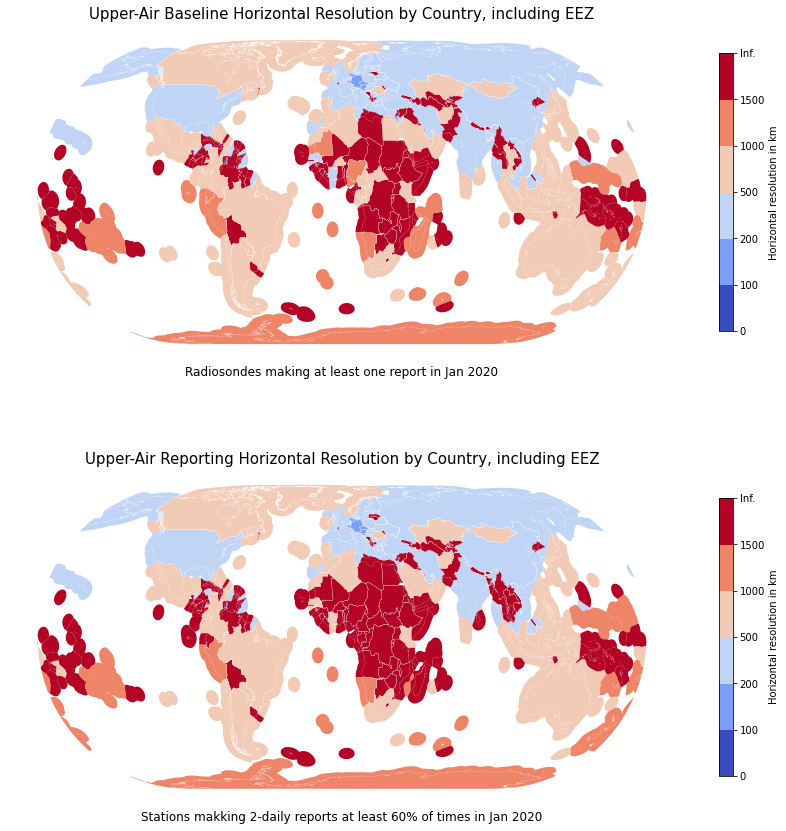

In [26]:
def plot(df,analysis_type):
    if analysis_type == "SYNOP":
        atitle = "Surface"
        vcenter,vmax = (200,1000) 
        boundaries =[0,50,100,150,200,250,500,750,1000]
        label_base = "Stations in OSCAR/Surface supposed to report in Jan 2020"
        label_rep = "Stations reporting 30% of GBON requirements at least 60% of times in Jan 2020"
 
    elif analysis_type == "UA":
        atitle = "Upper-Air"
        vcenter,vmax = (500,2000)
        boundaries =[0,100,200,500,1000,1500,2000]
        label_base = "Radiosondes making at least one report in Jan 2020"
        label_rep = "Stations makking 2-daily reports at least 60% of times in Jan 2020"
 
    cmap =  plt.get_cmap("coolwarm")
    norm =  colors.BoundaryNorm(boundaries,cmap.N)



    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,15))

    cmap_norm = "{}-{}".format(cmap.name,type(norm).__name__)
    title = "{} Baseline Horizontal Resolution by Country, including EEZ".format(atitle)
    plot_HR(df,"HR_baseline",title,ax1,norm=norm,cmap=cmap,vcenter=vcenter,vmax=vmax,ticks=boundaries,label=label_base)

    title = "{} Reporting Horizontal Resolution by Country, including EEZ".format(atitle)
    plot_HR(df,"HR_reporting",title,ax2,norm=norm,cmap=cmap,vcenter=vcenter,vmax=vmax,ticks=boundaries,label=label_rep)

    plt.savefig( os.path.join(outputdir, "GBON-res-{}.png".format(analysis_type)) )
    
    
plot(df_analysis,"SYNOP")
plot(df_analysis_ua,"UA")